In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import os
from PIL import Image
import zipfile
import random
import requests
from tqdm import tqdm
import tarfile
import shutil
from google.colab import drive
import numpy as np

random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
class CombinedDataset(Dataset):
    def __init__(self, avalanche_root, avalanche_file_list, non_avalanche_dir, transform=None, is_training=True):
        self.transform = transform
        self.is_training = is_training

        # Read avalanche images

        with open(avalanche_file_list, 'r') as f:
            lines = f.readlines()
            self.avalanche_files = [(os.path.join(avalanche_root, line.lstrip('/').strip()), 1)
                                  for line in lines]

        # Sample 500 non-avalanche images
        self.avalanche_files = self.avalanche_files[:500]


        # Get the correct non-avalanche directory based on training/testing
        if self.is_training:
            non_avalanche_path = os.path.join(non_avalanche_dir, 'train')
        else:
            non_avalanche_path = os.path.join(non_avalanche_dir, 'test')

        # Load non-avalanche images from the respective directory
        self.non_avalanche_files = [(os.path.join(non_avalanche_path, f), 0)
                                     for f in os.listdir(non_avalanche_path)
                                     if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Use only 500 non-avalanche images
        self.non_avalanche_files = self.non_avalanche_files[:500]


        print(f"Number of avalanche images: {len(self.avalanche_files)}")
        print(f"Number of non-avalanche images: {len(self.non_avalanche_files)}")

        # Combine both
        self.all_files = self.avalanche_files + self.non_avalanche_files
        if self.is_training:
            random.shuffle(self.all_files)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path, label = self.all_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
import os
import zipfile
import random
from shutil import move

def extract_zip(zip_path, extract_path):
    """Extract the zip file to the specified path"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted zip file to {extract_path}")


def extract_zip_and_split(zip_path, extract_path, train_ratio=0.8):
  """Extract the zip file and split data into train and test directories."""
  # Paths for train and test directories
  train_dir = os.path.join(extract_path, 'train')
  test_dir = os.path.join(extract_path, 'test')
  data_dir = os.path.join(extract_path, 'data')

  # Ensure directories exist
  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(test_dir, exist_ok=True)

  # Extract the zip file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
  print(f"Extracted zip file to {extract_path}")

  # Check if 'data' subdirectory exists
  if not os.path.exists(data_dir):
      print(f"Error: 'data' subdirectory not found in {extract_path}")
      return

  # List all files in the 'data' directory
  all_files = [
      os.path.join(data_dir, f) for f in os.listdir(data_dir)
      if os.path.isfile(os.path.join(data_dir, f))
  ]

  # Shuffle and split files
  random.shuffle(all_files)
  print(f"Total files: {len(all_files)}")
  train_size = int(len(all_files) * train_ratio)
  train_files = all_files[:train_size]
  test_files = all_files[train_size:]

  # Move files to train and test directories
  for file_path in train_files:
      move(file_path, os.path.join(train_dir, os.path.basename(file_path)))
  for file_path in test_files:
      move(file_path, os.path.join(test_dir, os.path.basename(file_path)))

  print(f"Split {len(all_files)} files: {len(train_files)} in train, {len(test_files)} in test")



def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((704, 704)),
        transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)],p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((704, 704)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

def setup_model():
    # Load pretrained ResNet50
    model = models.resnet50(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)  # 2 classes: avalanche / no avalanche
    )

    return model

In [6]:
non_avalanche_dir = 'datasets/no_avalanche'

In [7]:
# Example usage
zip_path = '/content/drive/MyDrive/wef-hack/randomimages.zip'
extract_path = 'datasets/no_avalanche'
extract_zip_and_split(zip_path, extract_path)

Extracted zip file to datasets/no_avalanche
Total files: 3000
Split 3000 files: 2400 in train, 600 in test


In [8]:
zip_path = '/content/drive/MyDrive/wef-hack/uibk_avalanches 2.zip'  # Update this path
extract_path = 'datasets'

# Extract the zip file
extract_zip(zip_path, extract_path)


Extracted zip file to datasets


In [9]:
# Setup paths for the extracted data
images_dir = os.path.join(extract_path, 'uibk_avalanches 2/images')
train_file = os.path.join(extract_path, 'uibk_avalanches 2/train.txt')
test_file = os.path.join(extract_path, 'uibk_avalanches 2/test.txt')
save_path = '/content/drive/MyDrive/model_checkpoints'

# Create save directory
os.makedirs(save_path, exist_ok=True)

In [10]:

# Get transforms
train_transform, test_transform = get_transforms()

# Create datasets
train_dataset = CombinedDataset(
    avalanche_root=images_dir,
    avalanche_file_list=train_file,
    non_avalanche_dir=non_avalanche_dir,
    transform=train_transform,
    is_training=True
)

test_dataset = CombinedDataset(
    avalanche_root=images_dir,
    avalanche_file_list=test_file,
    non_avalanche_dir=non_avalanche_dir,
    transform=test_transform,
    is_training=False
)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

# Setup and train model
model = setup_model()

Number of avalanche images: 500
Number of non-avalanche images: 500
Number of avalanche images: 478
Number of non-avalanche images: 500
Number of training images: 1000
Number of test images: 978


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [11]:
# prompt: i need code to print a few images from train loader, print 30 of them

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_loader' is defined as in your provided code

# Function to display images from the train loader
def display_images(loader, num_images=30):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig = plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = fig.add_subplot(6, 5, i + 1)  # Adjust the grid as needed
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i].item()}")
    plt.show()

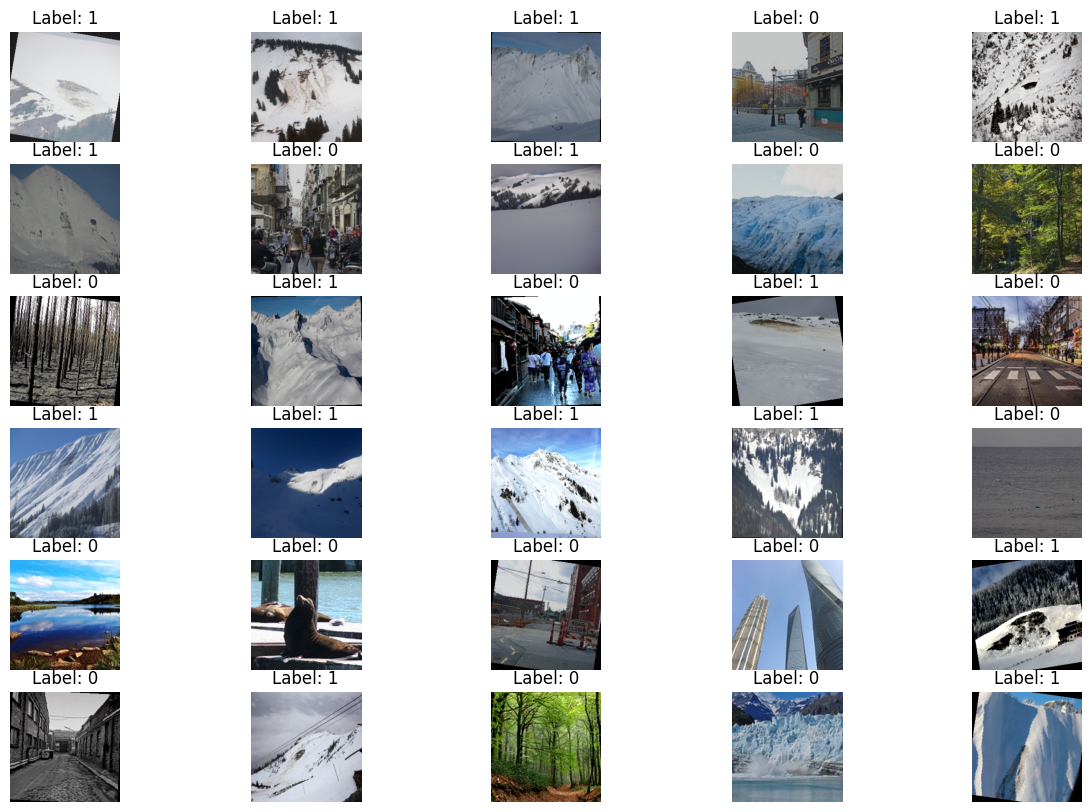

In [23]:
# Call the function to display 30 images
display_images(train_loader, num_images=30)

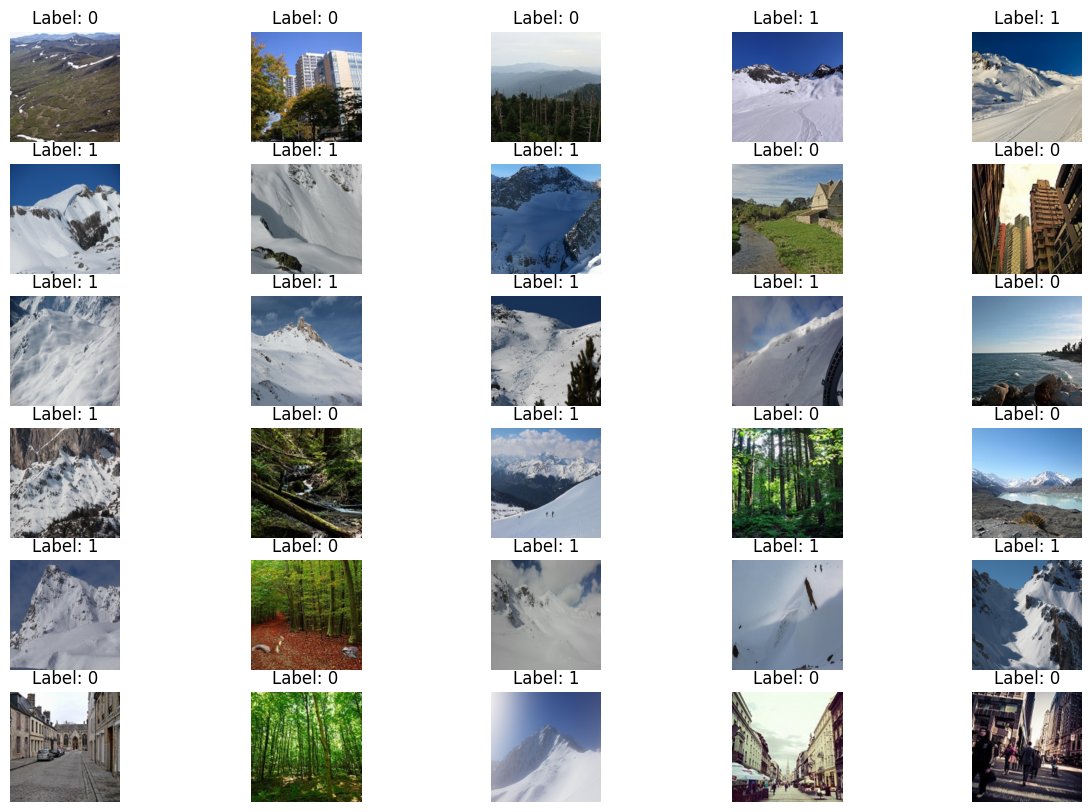

In [24]:
display_images(test_loader, num_images=30)

In [11]:
def compute_confusion_matrix(model, test_loader, device, epoch, save_path, num_classes):
    """
    Compute and save the confusion matrix for a multi-class classification model.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
        device: Device to perform computations on ('cpu' or 'cuda').
        epoch: Current epoch (used for naming the saved file).
        save_path: Directory to save the confusion matrix.
        num_classes: Number of classes in the classification task.
    """
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)  # NxN matrix for N classes

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)  # Get the predicted class

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    print(f'\nConfusion Matrix for Epoch {epoch}:')
    print(confusion_matrix)

    # Save confusion matrix
    os.makedirs(save_path, exist_ok=True)
    np.savetxt(
        os.path.join(save_path, f'confusion_matrix_epoch_{epoch}.txt'),
        confusion_matrix.cpu().numpy(),
        fmt='%d'
    )


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [28]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

best_test_loss = float('inf')
num_epochs = 2

# Lists to store train and test losses for plotting
train_losses = []
test_losses = []

# Simulated training and testing loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100. * correct / total

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    test_acc = 100. * correct / total

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Save confusion matrix for this epoch
    if epoch % 5 == 0:  # Save every 5 epochs
        compute_confusion_matrix(model, test_loader, device, epoch, save_path)

    scheduler.step(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), os.path.join(save_path, 'best_avalanche_model_2.pth'))


Testing: 100%|██████████| 8/8 [00:58<00:00,  7.37s/it]


Epoch [1/2]
Train Loss: 0.5114, Train Acc: 69.60%
Test Loss: 0.1940, Test Acc: 96.32%



Confusion Matrix for Epoch 0:
tensor([[464.,  36.],
        [  0., 478.]])


Testing: 100%|██████████| 8/8 [01:00<00:00,  7.61s/it]



Epoch [2/2]
Train Loss: 0.1807, Train Acc: 94.10%
Test Loss: 0.0851, Test Acc: 97.44%


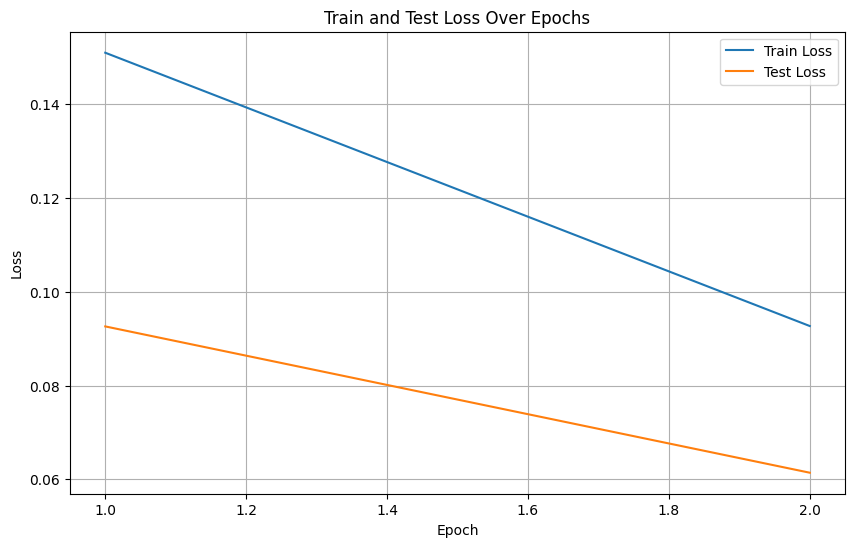

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

True Label: No Avalanche
Predicted Class: No Avalanche
Probabilities: [[0.94247574 0.05752421]]


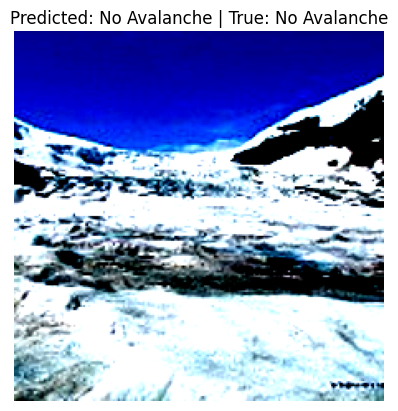

In [138]:
# Ensure the model is in evaluation mode
model.eval()

# Select an image from the test dataset
image, label = test_dataset[500]  # Replace 0 with any index

# Move the image to the same device as the model and add batch dimension
image = image.to(device).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(image)  # Get raw logits
    probabilities = torch.softmax(output, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()  # Get predicted class

# Map the prediction to human-readable labels (if available)
class_labels = ['No Avalanche', 'Avalanche']
predicted_label = class_labels[predicted_class]

# Print results
print(f"True Label: {class_labels[label]}")
print(f"Predicted Class: {predicted_label}")
print(f"Probabilities: {probabilities.cpu().numpy()}")

# Optional: Visualize the image
image_np = image.squeeze(0).cpu().numpy()  # Remove batch dimension
image_np = np.transpose(image_np, (1, 2, 0))  # Rearrange dimensions for visualization
plt.imshow(image_np)
plt.title(f"Predicted: {predicted_label} | True: {class_labels[label]}")
plt.axis('off')
plt.show()

### We now do the same but with classes

In [12]:
zip_path = '/content/drive/MyDrive/wef-hack/uibk_avalanches 2.zip'  # Update this path
extract_path = 'datasets'

# Extract the zip file
extract_zip(zip_path, extract_path)

Extracted zip file to datasets


In [13]:
class_label_map = {
    'none': 0,
    'slab': 1,
    'loose': 2,
    'glide': 3
}

In [14]:
# Setup paths for the extracted data
images_dir = os.path.join(extract_path, 'uibk_avalanches 2/images')
train_file = os.path.join(extract_path, 'uibk_avalanches 2/train.txt')
test_file = os.path.join(extract_path, 'uibk_avalanches 2/test.txt')

In [15]:
class CombinedDataset(Dataset):
    def __init__(self, avalanche_root, avalanche_file_list, non_avalanche_dir, transform=None, is_training=True):
        self.transform = transform
        self.is_training = is_training

        # Read avalanche images

        self.avalanche_files = []

        with open(avalanche_file_list, 'r') as f:
            lines = f.readlines()
            for line in lines:
                file_path = os.path.join(avalanche_root, line.lstrip('/').strip())

                folder_name = file_path.split(os.sep)[-2]  # Get the second last component of the path
                label = class_label_map.get(folder_name, -1)  # Map folder name to label

                if label == -1:
                    print(f"Warning: Folder '{folder_name}' not found in class_label_map")
                else:
                    self.avalanche_files.append((file_path, label))



        # Combine both
        self.all_files = self.avalanche_files
        if self.is_training:
            random.shuffle(self.all_files)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path, label = self.all_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:

# Get transforms
train_transform, test_transform = get_transforms()

# Create datasets
train_dataset = CombinedDataset(
    avalanche_root=images_dir,
    avalanche_file_list=train_file,
    non_avalanche_dir=non_avalanche_dir,
    transform=train_transform,
    is_training=True
)

test_dataset = CombinedDataset(
    avalanche_root=images_dir,
    avalanche_file_list=test_file,
    non_avalanche_dir=non_avalanche_dir,
    transform=test_transform,
    is_training=False
)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

Number of training images: 3612
Number of test images: 478


In [17]:
from collections import Counter

def class_counts(avalanche_file_list, avalanche_root, class_label_map):
    """
    Efficiently counts the occurrences of each class label in the avalanche dataset.

    Args:
        avalanche_file_list: Path to the file containing a list of avalanche image file paths.
        avalanche_root: Root directory of the avalanche images.
        class_label_map: A dictionary mapping folder names to class labels.

    Returns:
        A Counter object where keys are class labels and values are their counts.
    """

    class_counts = Counter()
    with open(avalanche_file_list, 'r') as f:
        for line in f:
            file_path = os.path.join(avalanche_root, line.lstrip('/').strip())
            folder_name = file_path.split(os.sep)[-2]
            label = class_label_map.get(folder_name, -1)
            if label != -1:
                class_counts[label] += 1
    return class_counts


# Example usage (assuming variables are defined as in your original code):
counts = class_counts(train_file, images_dir, class_label_map)
counts

Counter({3: 635, 2: 369, 0: 950, 1: 1658})

In [18]:
display_images(train_loader, num_images=30)

NameError: name 'display_images' is not defined

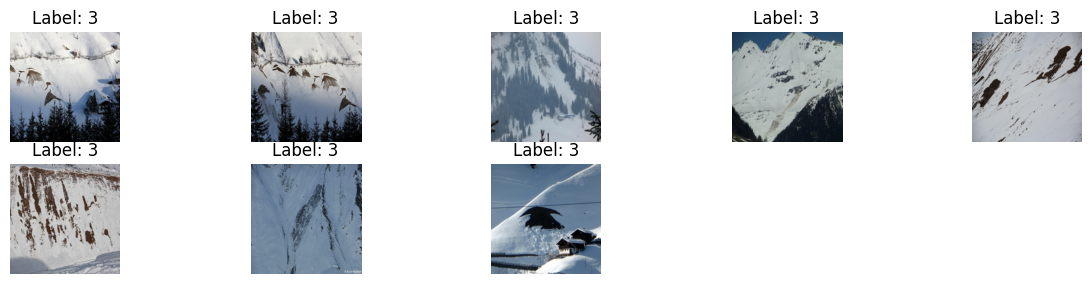

In [42]:
display_images(test_loader, num_images=30)

In [19]:
# prompt: save the first image from the train_dataloader

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_loader' is defined as in your provided code

# Function to save the first image from the data loader
def save_first_image(loader, filename="first_image.png"):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Take the first image from the batch
    img = images[0].numpy().transpose((1, 2, 0))

    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    img = (img * 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    img_pil.save(filename)

    # Save image



# Save the first image from the train loader
save_first_image(train_loader)

KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

def setup_model():
    # Load pretrained ResNet50
    model = models.resnet50(pretrained=True)

    # Freeze all layers
    #for param in model.parameters():
        #param.requires_grad = False

    # Modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 4)
    )

    return model

In [41]:
# Setup and train model
model = setup_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [42]:
# prompt: print parameters and if req grad true

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [43]:
def calculate_class_weights(class_counts):
    """
    Calculate class weights based on class counts.

    Args:
        class_counts: A Counter object with class labels as keys and their counts as values.

    Returns:
        A dictionary of class weights where keys are class labels and values are weights.
    """
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    class_weights = {
        label: total_samples / (num_classes * count)
        for label, count in class_counts.items()
    }
    return class_weights

class_weights = calculate_class_weights(counts)
weights_list = [class_weights[i] for i in sorted(class_weights.keys())]
print(class_weights)
weights_list

{3: 1.4220472440944882, 2: 2.4471544715447155, 0: 0.9505263157894737, 1: 0.5446320868516284}


[0.9505263157894737,
 0.5446320868516284,
 2.4471544715447155,
 1.4220472440944882]

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import os

weights = torch.tensor(weights_list).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

best_test_f1 = 0  # Changed from best_test_loss since higher F1 is better
num_epochs = 100
early_stopping_patience = 6
early_stopping_counter = 0

# Lists to store metrics for plotting
train_f1_scores = []
test_f1_scores = []
train_losses = []
test_losses = []

def compute_epoch_f1(model, data_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return f1_score(all_labels, all_predictions, average='weighted')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_predictions = []
    train_labels = []

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        train_predictions.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_f1 = f1_score(train_labels, train_predictions, average='weighted')
    train_f1_scores.append(train_f1)

    # Testing phase
    model.eval()
    test_loss = 0.0
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')
    test_f1_scores.append(test_f1)

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}')

    # Save confusion matrix for this epoch
    compute_confusion_matrix(model, test_loader, device, epoch, save_path, num_classes=4)

    # Check for early stopping using F1 score
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), os.path.join(save_path, 'best_avalanche_multiclass_model.pth'))
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs. Best test F1: {best_test_f1:.4f}")
        break

Testing: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch [1/100]
Train Loss: 1.2744, Train F1: 0.4551
Test Loss: 1.0989, Test F1: 0.5564



Confusion Matrix for Epoch 0:
tensor([[ 33.,  48.,  13.,  27.],
        [ 18., 155.,  22.,  34.],
        [  5.,  11.,  20.,  11.],
        [  2.,  10.,   6.,  63.]])


Testing: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


Epoch [2/100]
Train Loss: 1.0341, Train F1: 0.5921
Test Loss: 0.8871, Test F1: 0.6331



Confusion Matrix for Epoch 1:
tensor([[ 86.,  24.,   3.,   8.],
        [ 60., 135.,  28.,   6.],
        [ 12.,   5.,  28.,   2.],
        [ 15.,   6.,  11.,  49.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.64it/s]


Epoch [3/100]
Train Loss: 0.8223, Train F1: 0.6836
Test Loss: 0.7473, Test F1: 0.7118



Confusion Matrix for Epoch 2:
tensor([[ 96.,  15.,   4.,   6.],
        [ 52., 140.,  24.,  13.],
        [  8.,   1.,  33.,   5.],
        [  4.,   4.,   3.,  70.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


Epoch [4/100]
Train Loss: 0.6793, Train F1: 0.7507
Test Loss: 0.6884, Test F1: 0.7314



Confusion Matrix for Epoch 3:
tensor([[103.,   6.,   3.,   9.],
        [ 52., 142.,  29.,   6.],
        [  9.,   0.,  35.,   3.],
        [  6.,   4.,   4.,  67.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.67it/s]


Epoch [5/100]
Train Loss: 0.5595, Train F1: 0.7987
Test Loss: 0.6092, Test F1: 0.7610



Confusion Matrix for Epoch 4:
tensor([[ 92.,  11.,   3.,  15.],
        [ 40., 162.,  17.,  10.],
        [  6.,   0.,  35.,   6.],
        [  3.,   3.,   2.,  73.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch [6/100]
Train Loss: 0.4577, Train F1: 0.8331
Test Loss: 0.5961, Test F1: 0.7755



Confusion Matrix for Epoch 5:
tensor([[ 99.,  14.,   5.,   3.],
        [ 33., 166.,  28.,   2.],
        [  7.,   3.,  36.,   1.],
        [  4.,   5.,   6.,  66.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch [7/100]
Train Loss: 0.3757, Train F1: 0.8706
Test Loss: 0.5419, Test F1: 0.7806



Confusion Matrix for Epoch 6:
tensor([[ 92.,  21.,   2.,   6.],
        [ 25., 179.,  19.,   6.],
        [  9.,   2.,  32.,   4.],
        [  4.,   6.,   2.,  69.]])


Testing: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


Epoch [8/100]
Train Loss: 0.3288, Train F1: 0.8829
Test Loss: 0.5484, Test F1: 0.7938



Confusion Matrix for Epoch 7:
tensor([[109.,  11.,   1.,   0.],
        [ 35., 173.,  20.,   1.],
        [ 10.,   2.,  35.,   0.],
        [  8.,   8.,   5.,  60.]])


Testing: 100%|██████████| 60/60 [00:36<00:00,  1.66it/s]


Epoch [9/100]
Train Loss: 0.2758, Train F1: 0.9055
Test Loss: 0.5172, Test F1: 0.7862



Confusion Matrix for Epoch 8:
tensor([[107.,  11.,   1.,   2.],
        [ 42., 167.,  15.,   5.],
        [ 12.,   2.,  31.,   2.],
        [  8.,   4.,   0.,  69.]])


Testing: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


Epoch [10/100]
Train Loss: 0.2170, Train F1: 0.9291
Test Loss: 0.5939, Test F1: 0.7820



Confusion Matrix for Epoch 9:
tensor([[105.,  11.,   2.,   3.],
        [ 30., 166.,  29.,   4.],
        [ 10.,   1.,  35.,   1.],
        [  8.,   6.,   2.,  65.]])


Testing: 100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


Epoch [11/100]
Train Loss: 0.1840, Train F1: 0.9430
Test Loss: 0.5598, Test F1: 0.7968



Confusion Matrix for Epoch 10:
tensor([[ 98.,  11.,   1.,  11.],
        [ 23., 175.,  24.,   7.],
        [  3.,   1.,  39.,   4.],
        [  6.,   5.,   3.,  67.]])


Testing: 100%|██████████| 60/60 [00:35<00:00,  1.67it/s]


Epoch [12/100]
Train Loss: 0.1686, Train F1: 0.9444
Test Loss: 0.5416, Test F1: 0.8033



Confusion Matrix for Epoch 11:
tensor([[ 94.,  18.,   4.,   5.],
        [ 23., 189.,  14.,   3.],
        [  7.,   4.,  33.,   3.],
        [  4.,   7.,   3.,  67.]])


Epoch 13 training:   9%|▉         | 42/452 [00:22<03:39,  1.87it/s]


KeyboardInterrupt: 

In [ ]:
# Plot train and test losses after training
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
plt.plot(range(len(test_losses)), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Test Loss")
plt.show()

In [28]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from PIL import Image
def generate_saliency_map_from_test(model, test_loader, device, class_index=None):
    """
    Generate a saliency map for a random image from the test dataset.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        device: Device to run the computation ('cpu' or 'cuda').
        class_index: Index of the target class for which saliency is computed.
                     If None, the predicted class is used.

    Returns:
        Original image (PIL), saliency map (tensor), and class index.
    """
    model.eval()  # Set the model to evaluation mode

    # Get a single batch from the test loader
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Select the first image and label from the batch
    input_image = inputs[1].unsqueeze(0)  # Add batch dimension
    label = labels[1].item()

    input_image.requires_grad = True  # Enable gradient computation on the input

    # Forward pass
    output = model(input_image)

    # Use the predicted class if class_index is not provided
    if class_index is None:
        class_index = output.argmax(dim=1).item()

    # Compute gradients of the target class score w.r.t. the input image
    target_score = output[0, class_index]
    target_score.backward()  # Backpropagate to compute gradients

    # Get the gradients and compute saliency
    gradients = input_image.grad.data.abs()
    saliency, _ = torch.max(gradients, dim=1)  # Max over channels
    saliency = saliency.squeeze(0)  # Remove batch dimension

    return input_image.squeeze(0).cpu(), saliency, class_index, label


def visualize_saliency_map_from_test(input_image, saliency, class_index, label, save_path=None):
    """
    Visualize and optionally save the saliency map for the test image.

    Args:
        input_image: Tensor of the original test image.
        saliency: Saliency map as a tensor.
        class_index: Predicted class index.
        label: Actual class label.
        save_path: Path to save the saliency visualization (optional).
    """
    # Define normalization parameters (these should match the ones used during training)
    mean = torch.tensor([0.485, 0.456, 0.406])  # Mean used for normalization
    std = torch.tensor([0.229, 0.224, 0.225])   # Std used for normalization

    # De-normalize the image
    input_image = input_image.clone()  # Clone to avoid modifying the original tensor
    for c in range(3):  # Assuming a 3-channel image
        input_image[c] = input_image[c] * std[c] + mean[c]

    # Convert the de-normalized tensor back to a PIL image
    input_image = F.to_pil_image(input_image)

    # Normalize saliency for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Show original image
    ax[0].imshow(input_image)
    ax[0].axis('off')
    ax[0].set_title(f"Original Image\nTrue Class: {label}")

    # Show saliency map
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    ax[1].set_title(f"Saliency Map\nPredicted Class: {class_index}")

    # Save visualization if a path is provided
    if save_path:
        plt.savefig(save_path)
    plt.show()



In [22]:
# Path to the saved model weights
model_path = 'drive/MyDrive/model_checkpoints/best_avalanche_multiclass_model.pth'

# Initialize the model
model = setup_model()

# Load the saved state dictionary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device
model.to(device)
model.eval()  # Set the model to evaluation mode

print("Model loaded and ready for evaluation!")

<ipython-input-22-d6a28993eaf3>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded and ready for evaluation!


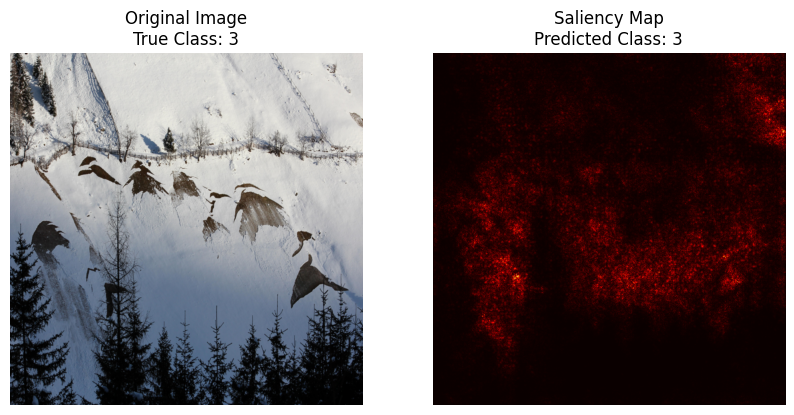

In [29]:
# Generate the saliency map from the test dataset
input_image, saliency, predicted_class, true_class = generate_saliency_map_from_test(
    model=model,
    test_loader=test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Visualize the saliency map
visualize_saliency_map_from_test(
    input_image=input_image,
    saliency=saliency,
    class_index=predicted_class,
    label=true_class,
    save_path="test_saliency_map.png"
)